In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


## Cargar el modelo victima

In [58]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar estructura del modelo y adaptarla a 10 clases
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# Cargar pesos
resnet50.load_state_dict(torch.load("CIFAR10_resnet50.pth", map_location=device))
resnet50 = resnet50.to(device)
resnet50.eval()

c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\artur\AppData\Local\Temp\ipykernel_14052\1521559691.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future re

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Cargar el dataset CIFAR10

In [59]:
transform = transforms.Compose([
    transforms.Resize(224),  # Importante para ResNet-50
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar dataset de prueba
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

# Clases de CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Obtener un batch de 25 imágenes
dataiter = iter(loader)
images, labels = next(dataiter)

Files already downloaded and verified


## Visualizar el dataset CIFAR10



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


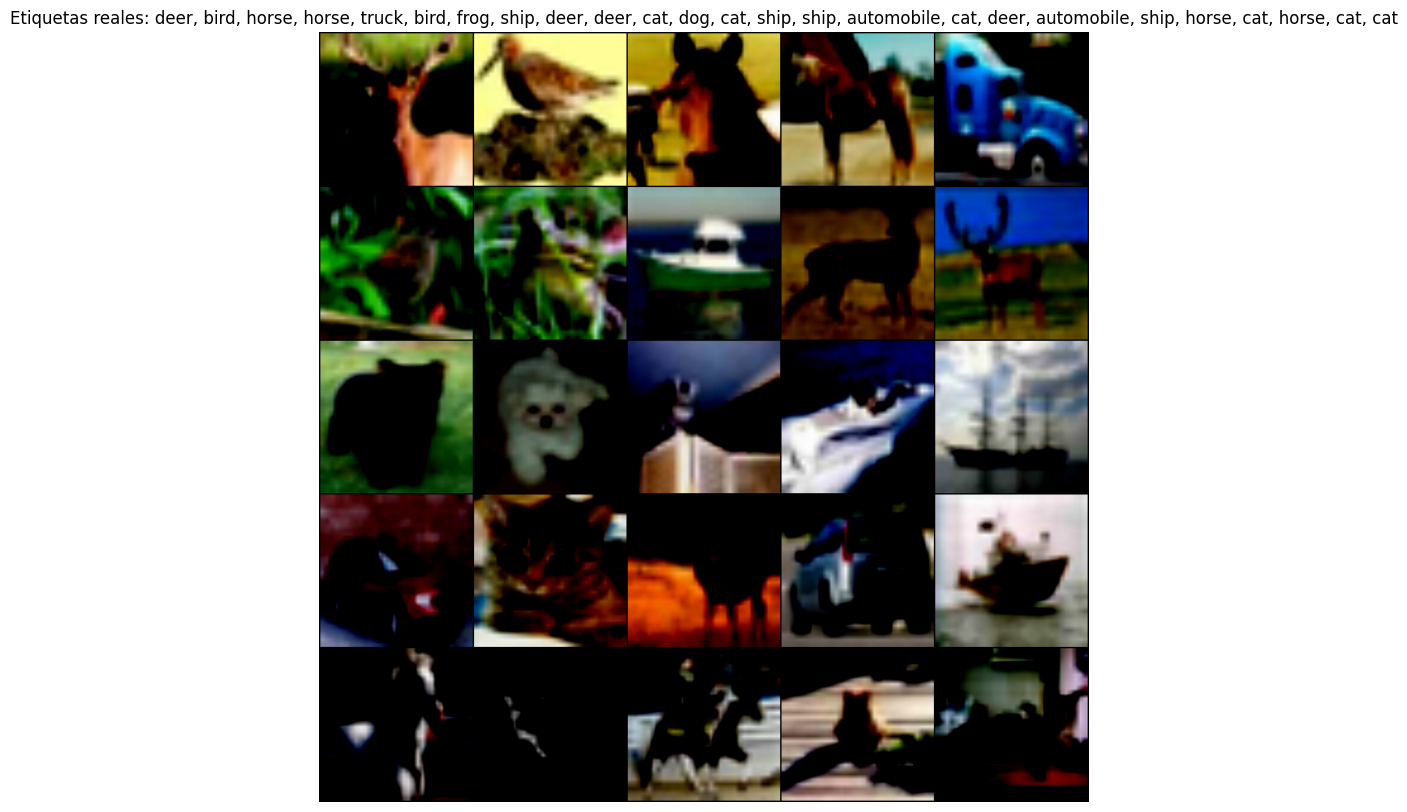

In [60]:
# Función para desnormalizar y mostrar una cuadrícula
def imshow(imgs, labels):
    imgs = torchvision.utils.make_grid(imgs, nrow=5, padding=2)
    npimg = imgs.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Etiquetas reales: " + ", ".join(classes[labels[i]] for i in range(25)))
    plt.show()

# Mostrar las imágenes
imshow(images, labels)

## FGSM


In [61]:
# Definición de métodos de ataque (FGSM)
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [62]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    model.eval()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Hacer que cada imagen se procese individualmente (batch de 1)
        for i in range(data.size(0)):
            input_img = data[i].unsqueeze(0)
            label = target[i].unsqueeze(0)

            input_img.requires_grad = True
            output = model(input_img)
            init_pred = output.max(1, keepdim=True)[1]

            if init_pred.item() != label.item():
                continue

            # Calcular la pérdida y gradiente
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            model.zero_grad()
            loss.backward()

            # Obtener el signo del gradiente
            data_grad = input_img.grad.data
            perturbed_data = input_img + epsilon * data_grad.sign()
            perturbed_data = torch.clamp(perturbed_data, 0, 1)

            # Volver a predecir con la imagen perturbada
            output = model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]

            if final_pred.item() == label.item():
                correct += 1
                # Guardar ejemplo exitoso
                if (epsilon != 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                # Guardar ejemplo adversarial
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader.dataset))
    print(f"Epsilon: {epsilon}\tPrecisión = {final_acc:.4f}")

    return final_acc, adv_examples

In [63]:
# Definimos una lista de al menos 5 valores de epsilon para el estudio
epsilons = [0, 0.025, 0.05, 0.1, 0.15]

batch_size = 128  # 🔥 Puedes aumentar si tienes GPU potente
torch.backends.cudnn.benchmark = True
print(f"Usando: {device}")

accuracies = []
adv_examples_all = []

print("Ejecutando ataque FGSM para distintos valores de epsilon...")
for eps in epsilons:
    acc, adv_examples = test(resnet50, device, loader, eps)
    accuracies.append(acc)
    adv_examples_all.append(adv_examples)

Usando: cuda
Ejecutando ataque FGSM para distintos valores de epsilon...
Epsilon: 0	Precisión = 0.5141
Epsilon: 0.025	Precisión = 0.1773
Epsilon: 0.05	Precisión = 0.1470
Epsilon: 0.1	Precisión = 0.1177
Epsilon: 0.15	Precisión = 0.1019


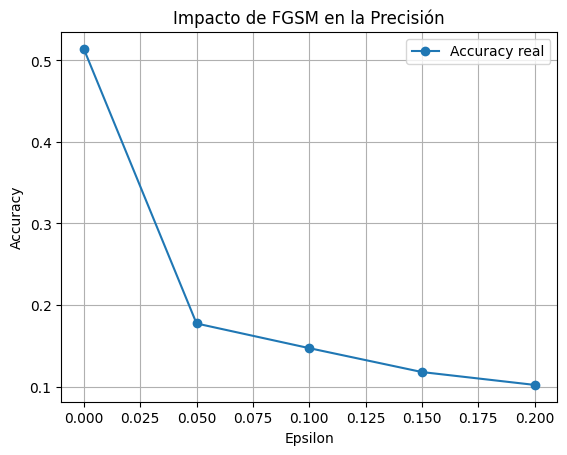

In [64]:
epsilons = np.array([0, 0.05, 0.1, 0.15, 0.2]).reshape(-1, 1)  # Valores de epsilon
accuracies = np.array(accuracies).reshape(-1, 1)  # Precisión obtenida

# Ajustar regresión lineal
model = LinearRegression()
model.fit(epsilons, accuracies)

# Graficar relación entre epsilon y accuracy
plt.plot(epsilons, accuracies, marker='o', label="Accuracy real")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Impacto de FGSM en la Precisión")
plt.grid(True)
plt.legend()
plt.show()

In [65]:
selected_epsilon = 0.15
epsilons = list(epsilons)
index = epsilons.index(selected_epsilon)
selected_adv_examples = adv_examples_all[index]

print(f"Se han seleccionado ejemplos adversarios generados con epsilon = {selected_epsilon}.")

Se han seleccionado ejemplos adversarios generados con epsilon = 0.15.


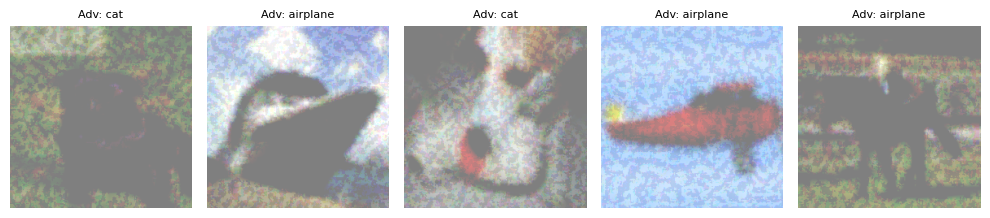

In [66]:
def plot_adversarial_examples(examples, labels):
    num_examples = min(len(examples), 5)  # Mostrar hasta 25 ejemplos si están disponibles
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))  # Crear una rejilla 5x5

    for i in range(num_examples):
        ax = axes.flat[i]  # Acceder a cada eje en la rejilla
        img = examples[i]  # Ya es un array NumPy, no necesita transformación
        img = img / 2 + 0.5  # Desnormalizar
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(f"Adv: {classes[labels[i]]}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


adversarial_images = [ex[2] for ex in selected_adv_examples[:25]]  # Extrae solo las imágenes adversariales
adversarial_labels = [label for _, label, _ in selected_adv_examples[:25]]  # Extrae los labels finales

plot_adversarial_examples(adversarial_images, adversarial_labels)

## Defensas frente FGSM

In [67]:
# FGSM Attack Function
def fgsm_attack(data, epsilon, gradient):
    perturbed_image = data + epsilon * gradient.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Entrenamiento adversarial
def train_adversarial(model, train_loader, optimizer, criterion, device, epsilon):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        data_grad = data.grad.data
        adv_data = fgsm_attack(data, epsilon, data_grad)
        optimizer.zero_grad()
        output_adv = model(adv_data)
        loss_adv = criterion(output_adv, target)
        loss_adv.backward()
        optimizer.step()

# Autoencoder para detección
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, output_padding=1, padding=1), nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train_autoencoder(autoencoder, train_loader, device):
    optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    autoencoder.train()
    for epoch in range(3):
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = autoencoder(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()


In [68]:
# Dataset con transformaciones defensivas
transform_defended = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_defended = DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_defended),
    batch_size=64, shuffle=True
)

# Entrenar con ejemplos adversarios
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_adversarial(resnet50, train_loader_defended, optimizer, criterion, device, epsilon=0.05)

# Entrenar autoencoder con datos limpios
autoencoder = Autoencoder().to(device)
train_autoencoder(autoencoder, train_loader_defended, device)


Files already downloaded and verified


## Visualización de las defensas

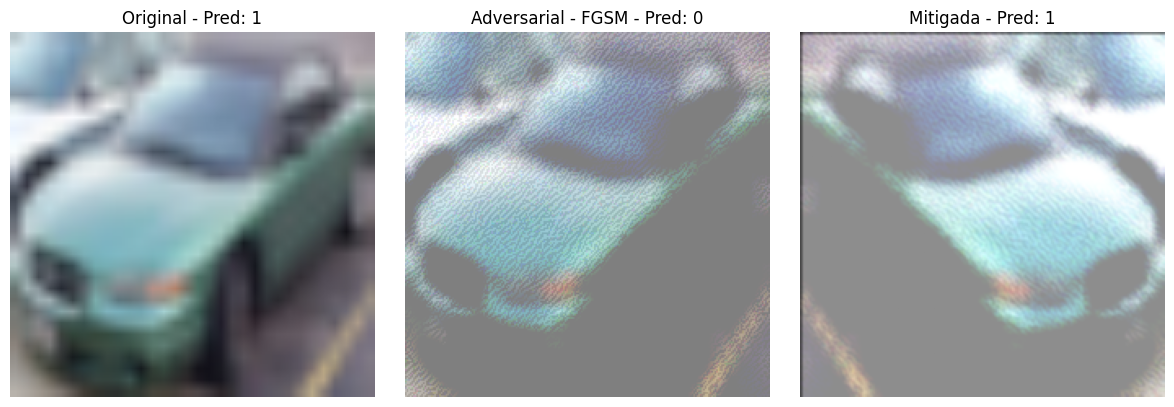

In [85]:
# Obtener una única imagen del test set
image, label = next(iter(loader))
image, label = image[0].unsqueeze(0).to(device), label[0].unsqueeze(0).to(device)

# Predicción original
resnet50.eval()
orig_pred = resnet50(image).argmax(dim=1).item()

# Crear imagen adversarial
image.requires_grad = True
output = resnet50(image)
loss = F.nll_loss(F.log_softmax(output, dim=1), label)
resnet50.zero_grad()
loss.backward()
data_grad = image.grad.data
epsilon = 0.1
adv_image = fgsm_attack(image, epsilon, data_grad)

# Predicción adversarial
with torch.no_grad():
    adv_pred = resnet50(adv_image).argmax(dim=1).item()

# Aplicar transformaciones defensivas a la imagen adversarial
adv_pil = to_pil_image((adv_image.squeeze().cpu() * 0.5) + 0.5)
defended_tensor = transform_defended(adv_pil).unsqueeze(0).to(device)
defended_pred = resnet50(defended_tensor).argmax(dim=1).item()

# Visualización de resultados
def imshow(img, title):
    img = img.squeeze().detach().cpu().numpy()
    img = (img * 0.5) + 0.5
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
imshow(image, f"Original - Pred: {orig_pred}")
plt.subplot(1, 3, 2)
imshow(adv_image, f"Adversarial - FGSM - Pred: {adv_pred}")
plt.subplot(1, 3, 3)
imshow(defended_tensor, f"Mitigada - Pred: {defended_pred}")
plt.tight_layout()
plt.show()